# Classifying Fashion-MNIST


Now we're going to build a Artificial Neural Network that can solve a (formerly) difficult problem, identifying text in an image. Here we'll use the MNIST dataset which consists of greyscale handwritten digits. Each image is 28x28 pixels, you can see a sample below

<img src='asset/mnist.png'>

Our goal is to build a Artificial Neural network that can take one of these images and predict the digit in the image.

First up, we need to get our dataset. This is provided through the `torchvision` package. The code below will download the MNIST dataset, then create training and test datasets for us. Don't worry too much about the details here, you'll learn more about this later.

* ### Importing necessary packages

In [1]:
# Import necessary packages

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import helper1

import matplotlib.pyplot as plt

* ### Defining pipeline for loading and applying transformation to the dataset

In [2]:
#Define a transform to normalize the data
from torchvision import datasets,transforms
transform= transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True,
                          transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False,
                          transform=transform)
testloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

We have the training data loaded into `trainloader` and we make that an iterator with `iter(trainloader)`. Later, we'll use this to loop through the dataset for training, like

```python
for image, label in trainloader:
    ## do things with images and labels
```

You'll notice I created the `trainloader` with a batch size of 64, and `shuffle=True`. The batch size is the number of images we get in one iteration from the data loader and pass through our network, often called a *batch*. And `shuffle=True` tells it to shuffle the dataset every time we start going through the data loader again. But here I'm just grabbing the first batch so we can check out the data. We can see below that `images` is just a tensor with size `(64, 1, 28, 28)`. So, 64 images per batch, 1 color channel, and 28x28 images.

* ### Testing the data pipeline

In [3]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('Data type of images: ',type(images))
print('Shape of images: ',images.shape)
print('Shape of labels: ',labels.shape)

Data type of images:  <class 'torch.Tensor'>
Shape of images:  torch.Size([64, 1, 28, 28])
Shape of labels:  torch.Size([64])


* ### Visualizing some data

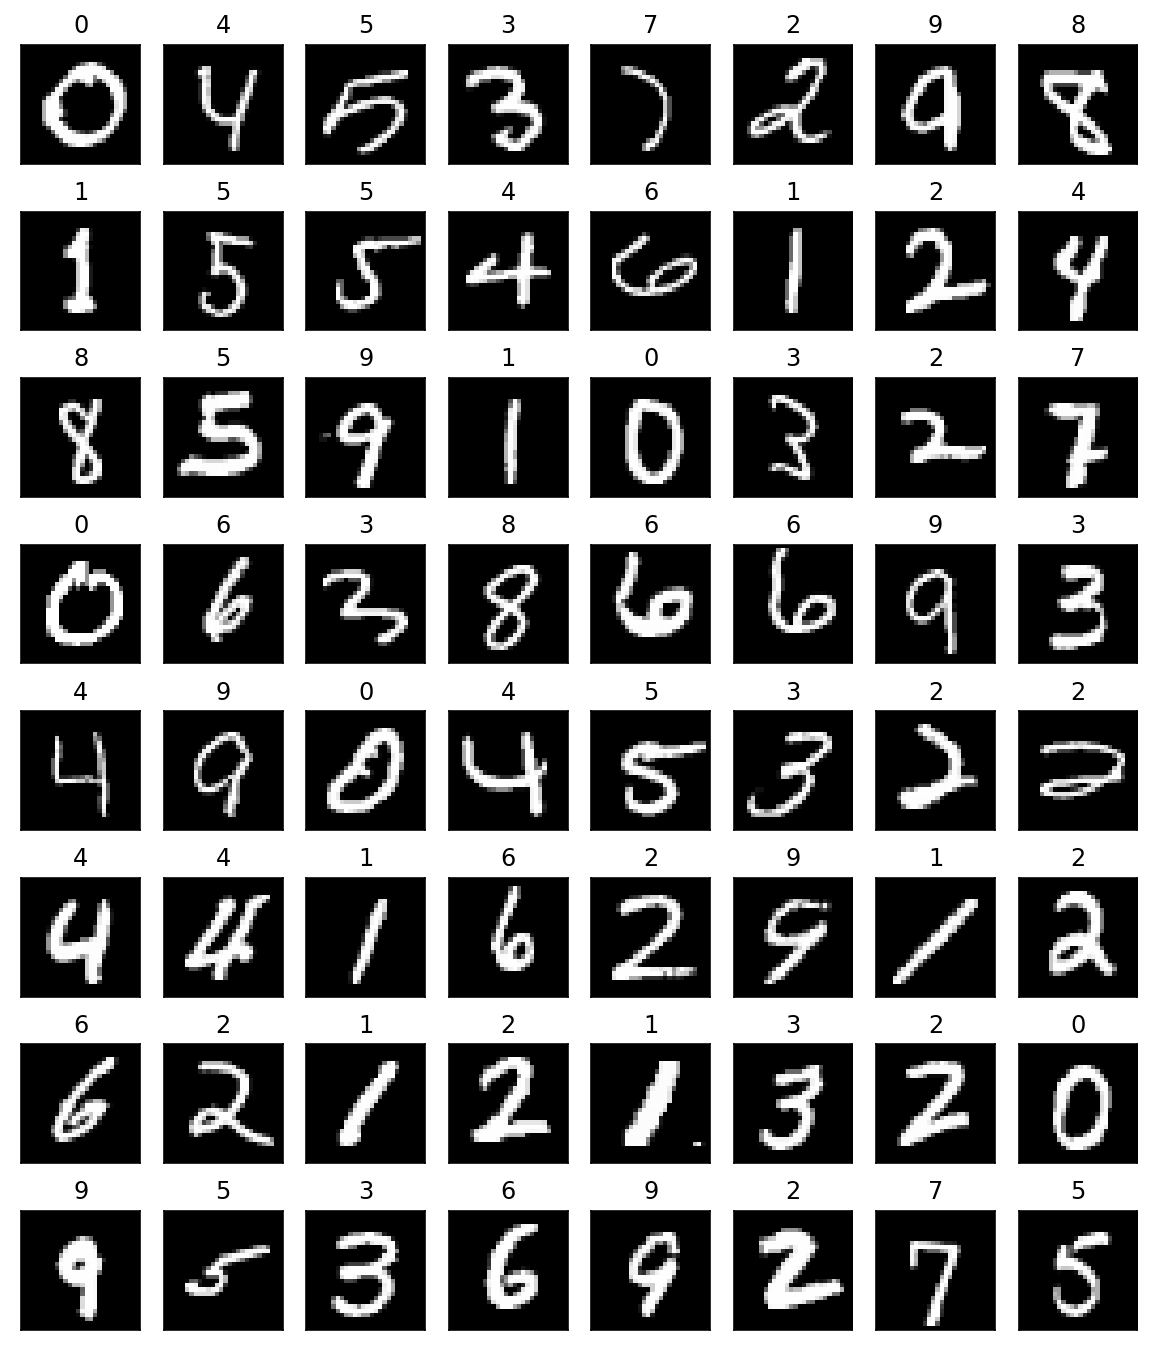

In [4]:
images,labels=next(iter(trainloader))

fig=plt.figure(figsize=(10,12))

for i in range(64):
    ax=fig.add_subplot(8,8,i+1,yticks=[],xticks=[])
    ax.imshow(images[i].numpy().squeeze(),cmap='Greys_r')
    ax.set_title(str(labels[i].item()))

## Building networks with PyTorch

PyTorch provides a module `nn` that makes building networks much simpler. Here I am building
a Artificial Neural Network with A Input Layer with (24*24)=784 input, First Hidden Layer with 256 ,  Second Hidden Layer with 128 ,A Output Layer with 10 units

In [9]:
from torch import nn
from torch import optim

model = nn.Sequential(nn.Linear(784, 256),
                      nn.ReLU(),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=10, bias=True)
  (7): LogSoftmax()
)


In [10]:
# Defining the loss function and Optimizer
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

* ### Training the model

In [11]:
epochs = 30
steps = 0
test_loss_min=np.Inf
train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                # Flatten MNIST images into a 784 long vector
                images = images.view(images.shape[0], -1)
                
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
        if (test_loss/len(testloader))<test_loss_min:
            torch.save(model.state_dict(), 'latest_model.pt')
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        test_loss_min,
        (test_loss/len(testloader))))
            test_loss_min=(test_loss/len(testloader))

Epoch: 1/30..  Training Loss: 2.230..  Test Loss: 2.103..  Test Accuracy: 0.480
Validation loss decreased (inf --> 2.103091).  Saving model ...
Epoch: 2/30..  Training Loss: 1.655..  Test Loss: 1.128..  Test Accuracy: 0.710
Validation loss decreased (2.103091 --> 1.127575).  Saving model ...
Epoch: 3/30..  Training Loss: 0.839..  Test Loss: 0.654..  Test Accuracy: 0.810
Validation loss decreased (1.127575 --> 0.654267).  Saving model ...
Epoch: 4/30..  Training Loss: 0.577..  Test Loss: 0.517..  Test Accuracy: 0.846
Validation loss decreased (0.654267 --> 0.517341).  Saving model ...
Epoch: 5/30..  Training Loss: 0.480..  Test Loss: 0.447..  Test Accuracy: 0.871
Validation loss decreased (0.517341 --> 0.447012).  Saving model ...
Epoch: 6/30..  Training Loss: 0.422..  Test Loss: 0.399..  Test Accuracy: 0.883
Validation loss decreased (0.447012 --> 0.398807).  Saving model ...
Epoch: 7/30..  Training Loss: 0.383..  Test Loss: 0.367..  Test Accuracy: 0.893
Validation loss decreased (0.39

* As we have seen that validation loss is still decreasing so we will train the model for
more epochs

In [12]:
epochs=15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                # Flatten MNIST images into a 784 long vector
                images = images.view(images.shape[0], -1)
                
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
        if (test_loss/len(testloader))<test_loss_min:
            torch.save(model.state_dict(), 'latest_model.pt')
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        test_loss_min,
        (test_loss/len(testloader))))
            test_loss_min=(test_loss/len(testloader))

Epoch: 1/15..  Training Loss: 0.151..  Test Loss: 0.148..  Test Accuracy: 0.957
Validation loss decreased (0.151838 --> 0.148181).  Saving model ...
Epoch: 2/15..  Training Loss: 0.146..  Test Loss: 0.142..  Test Accuracy: 0.959
Validation loss decreased (0.148181 --> 0.142286).  Saving model ...
Epoch: 3/15..  Training Loss: 0.142..  Test Loss: 0.141..  Test Accuracy: 0.960
Validation loss decreased (0.142286 --> 0.141421).  Saving model ...
Epoch: 4/15..  Training Loss: 0.138..  Test Loss: 0.138..  Test Accuracy: 0.960
Validation loss decreased (0.141421 --> 0.137703).  Saving model ...
Epoch: 5/15..  Training Loss: 0.134..  Test Loss: 0.136..  Test Accuracy: 0.960
Validation loss decreased (0.137703 --> 0.136103).  Saving model ...
Epoch: 6/15..  Training Loss: 0.131..  Test Loss: 0.126..  Test Accuracy: 0.964
Validation loss decreased (0.136103 --> 0.125965).  Saving model ...
Epoch: 7/15..  Training Loss: 0.127..  Test Loss: 0.125..  Test Accuracy: 0.964
Validation loss decreased 

* ### Now we have reached a decent accuracy. Now we will evaluate our model

In [17]:
with torch.no_grad():
    accuracy=0
    for images, labels in testloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
                
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
                
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
        
accuracy=accuracy
print(f'The Accuracy of the model is: {(accuracy/len(testloader))*100}%')

The Accuracy of the model is: 97.10487365722656%


* ### Visualizing some test

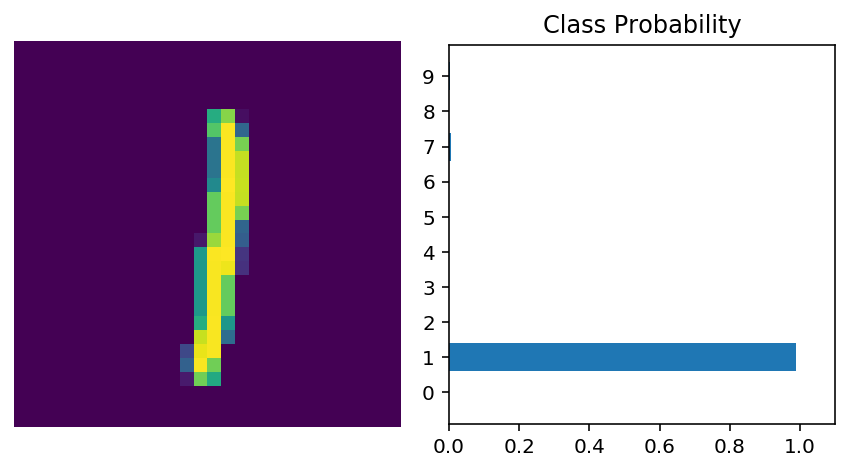

In [18]:
%matplotlib inline
import helper1

images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
helper1.view_classify(img.view(1, 28, 28), ps)

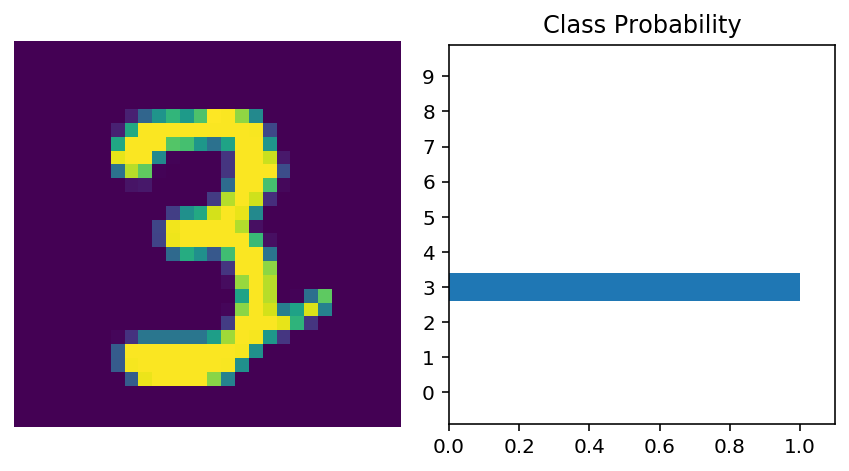

In [21]:
# Another test
img = images[3].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
helper1.view_classify(img.view(1, 28, 28), ps)

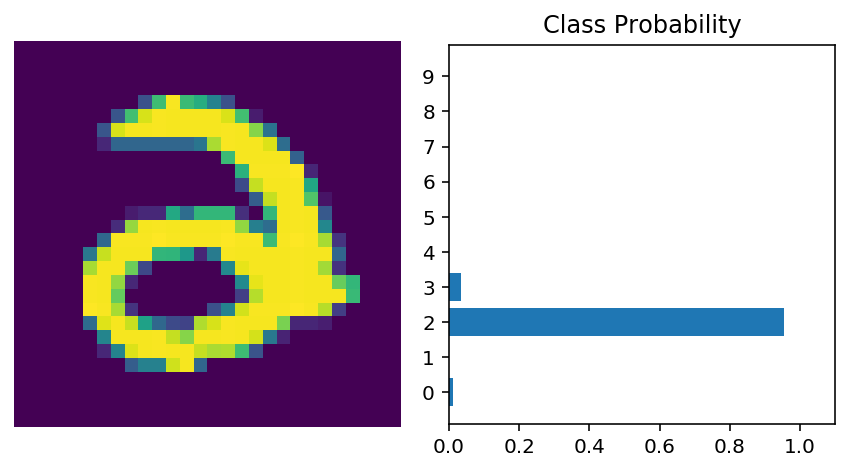

In [22]:
# Another test
img = images[30].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
helper1.view_classify(img.view(1, 28, 28), ps)

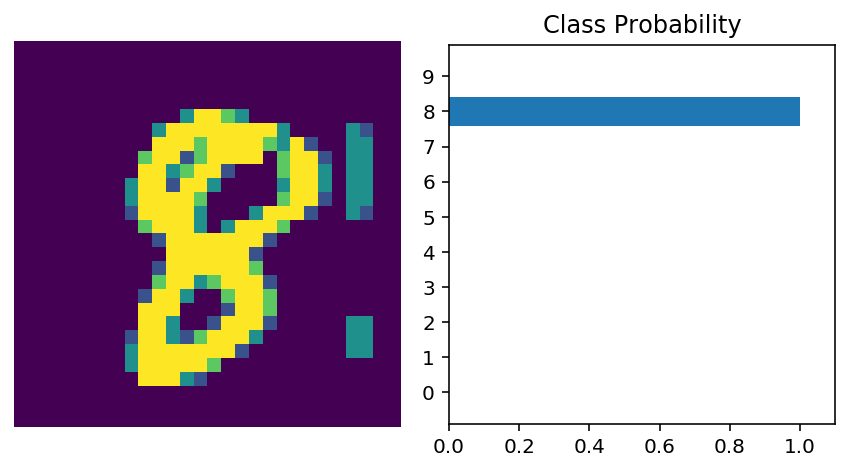

In [23]:
# Another test
img = images[23].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
helper1.view_classify(img.view(1, 28, 28), ps)

* ### So we can conclude that our model is performing preety well.

# Thank you.

### If you have any query or suggesation about this project , please feel free to contact  me through email : dasjoy498@gmail.com